# Libraries

In [1]:
import json
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import cv2
import shapely as sh

# Functions

In [2]:
def centroid_polygon(x: list, y: list) -> tuple[float, float, list]:
    """
    Calculate the centroid of a polygon defined by its vertices.

    :param x: x-coordinates of the polygon vertices
    :param y: y-coordinates of the polygon vertices

    :return: output[0] = x centroid, output[1] = y centroid and output[2] = coordinates of the polygon in tuple format
    """

    coords = []
    for i, j in zip(x, y):
        coords.append((i, j))
    polyg = sh.geometry.Polygon(coords)
    centre = polyg.centroid

    return centre.x, centre.y, coords


def transport_polygon(x: list, y: list, x_new: float, y_new: float) -> tuple[float, float]:
    """
    Translate a polygon defined by its vertices to a new position.

    :param x: x-coordinates of the polygon vertices
    :param y: y-coordinates of the polygon vertices
    :param x_new: new x-coordinate for the centroid of the polygon
    :param y_new: new y-coordinate for the centroid of the polygon

    :return: output[0] = new x-coordinates of the polygon vertices and output[1] = new y-coordinates of the polygon vertices
    """

    x_g, y_g, coords = centroid_polygon(x, y)
    dx = -x_g
    dy = -y_g

    # Translate the polygon to the origin
    transl_polygon_00 = sh.affinity.translate(sh.geometry.Polygon(coords), xoff=dx, yoff=dy)

    # Translate the polygon to the new position
    transl_polygon_xy = sh.affinity.translate(transl_polygon_00, xoff=x_new, yoff=y_new)

    # Extract the new x and y coordinates
    x_trans = [po[0] for po in transl_polygon_xy.exterior.coords]
    y_trans = [po[1] for po in transl_polygon_xy.exterior.coords]

    return x_trans, y_trans


def size_polygon(x: list, y: list) -> tuple[float, float]:
    """
    Calculate the size of a polygon defined by its vertices.

    :param x: x-coordinates of the polygon vertices
    :param y: y-coordinates of the polygon vertices

    :return: output[0] = length in x direction and output[1] = length in y direction
    """

    x_min = min(x)
    x_max = max(x)
    y_min = min(y)
    y_max = max(y)
    l_x = x_max - x_min
    l_y = y_max - y_min

    return l_x, l_y


def exclude_cont_bound(myconts: dict, n_x: float, n_y: float) -> dict:
    """
    Exclude contours that touch the boundary of the image.
    
    :param myconts: Dictionary of contours
    :param n_x: Width of the image or criterion for exclusion
    :param n_y: Height of the image or criterion for exclusion

    :return: Filtered dictionary of contours that do not touch the boundary
    """
    
    myconts_copy = myconts.copy()
    for i in myconts:
        i_contour = myconts[i]
        for j in range(len(i_contour)):
            x, y = i_contour[j][0]
            if x == 0 or y == 0 or x >= n_x or y >= n_y:
                save_or_not_save = False
                break
        else:
            save_or_not_save = True
        if save_or_not_save == False:
          del myconts_copy[i]
          
    return myconts_copy


def extract_contours(contours: dict) -> dict: 
    """
    Extract contours from a list of contours and return them as a dictionary.
    
    :param contours: Contours to be processed
    
    :return: Contour points. Each index of the dictionary corresponds to a contour.
    """

    myconts = {}
    for i, contour in enumerate(contours):
        myconts[str(i)] = np.array(contour)
        
    return myconts


def process_images_to_json(filepath: str, output_json: str, width: int = 2500, height: int = 2500) -> None:
    """
    Process images to extract contours and save them in a JSON file.

    :param filepath: Path to the image or directory containing images
    :param output_json: Path to the output JSON file
    :param width: Width of the images (default is 2500)
    :param height: Height of the images (default is 2500)
    """

    contours_json = {}
    image_area = width * height 

    if os.path.isdir(filepath):
        files = [os.path.join(filepath, f) for f in os.listdir(filepath) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    elif isinstance(filepath, (list, tuple)):
        files = filepath 
    else:
        files = [filepath] 

    # Read each image and process contours
    for filename in files:
        img = cv2.imread(filename)
        if img is None:
            print(f"Error to read image: {filename}")
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, threshold = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
        contours, hierarchy = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        # Get contour
        myconts = extract_contours(contours)

        # Exclude contours that touch the boundary
        myc = exclude_cont_bound(myconts, width-1, height-1)

        # Create a dictionary to save contours in JSON format
        image_key = os.path.basename(filename)
        contours_json[image_key] = {}

        # Image background size to aggregate-mortar
        l_xmax = []
        l_ymax = []
        for idx, contour in myc.items():
            coords = contour[:, 0, :]
            x_coords = coords[:, 0].tolist()
            y_coords = coords[:, 1].tolist()
            res = size_polygon(x_coords, y_coords)
            l_xmax.append(res[0])
            l_ymax.append(res[1])
        l_xback = max(l_xmax)
        l_yback = max(l_ymax)
        l_max = max([l_xback, l_yback])
        # Colocar o tamanho do background como o tamanho do maior contorno e img na base 2
        
        # Save contours and their areas in the JSON format
        for idx, contour in myc.items():
            coords = contour[:, 0, :]
            x_coords = coords[:, 0].tolist()
            y_coords = coords[:, 1].tolist()
            # x_coords_trans, y_coords_trans = transport_polygon(x_coords, y_coords, l_max/2, l_max/2)
            area = cv2.contourArea(contour)
            q = float(area / image_area)
            contours_json[image_key][f"{idx}"] = {'x': x_coords, 'y': y_coords, 'q': q, 'lmax': l_max}

    with open(output_json, 'w') as f:
        json.dump(contours_json, f, indent=4)
    print(f"Contours extracted and saved to {output_json}")


def plot_contours_from_json(json_file: str, keys_to_plot: list = None, width: int = 2500, height: int = 2500) -> None:
    """
    Plot contours from a JSON file in a single figure with subplots:
    Left: all contours filled.
    Right: a single random contour filled on black background with its q value.

    :param json_file: Path to the JSON file containing contours
    :param keys_to_plot: List of keys (image names) to plot. If None, plot all keys
    :param width: Width of the images (default is 2500)
    :param height: Height of the images (default is 2500)
    """

    # Load contours from JSON file
    with open(json_file, 'r') as f:
        contours_data = json.load(f)

    # Determine keys to plot
    keys = keys_to_plot if keys_to_plot else contours_data.keys()

    for image_name in keys:
        if image_name not in contours_data:
            print(f"Warning: {image_name} not found in contours data!")
            continue

        contours = contours_data[image_name]
        img_all = np.zeros((height, width), dtype=np.uint8)

        contour_list = []
        q_values = []  # Armazena valores de q para cada contorno

        for _, contour in contours.items():
            x = np.array(contour["x"])
            y = np.array(contour["y"])
            pts = np.vstack((x, y)).T.astype(np.int32).reshape((-1, 1, 2))
            contour_list.append(pts)
            q_values.append(contour["q"])
            cv2.drawContours(img_all, [pts], -1, (255), thickness=cv2.FILLED)

        # Random contour image
        img_random = np.zeros((height, width), dtype=np.uint8)
        q_random = None
        if contour_list:
            random_idx = random.randint(0, len(contour_list) - 1)
            random_contour = contour_list[random_idx]
            q_random = q_values[random_idx]
            cv2.drawContours(img_random, [random_contour], -1, (255), thickness=cv2.FILLED)

        # Plot with subplots
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(img_all, cmap='gray')
        axes[0].set_title(f"All Contours - {image_name}")
        axes[0].axis('off')

        axes[1].imshow(img_random, cmap='gray')
        if q_random is not None:
            axes[1].set_title(f"Random Contour - {image_name}       q = {q_random:.6f}")
        else:
            axes[1].set_title(f"Random Contour - {image_name}")
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()


def crop_contours(
    json_file: str,
    output_dir: str,
    canvas_size: int = 512  # ou use l_max se quiser tamanho variável
) -> None:
    """
    Cria imagens com contornos centrados (de fato), transladando o contorno
    para o centro da imagem antes de desenhar.
    """

    os.makedirs(output_dir, exist_ok=True)

    with open(json_file, 'r') as f:
        contours_data = json.load(f)

    for image_name, contours in contours_data.items():
        for idx, contour in contours.items():
            x_coords = contour["x"]
            y_coords = contour["y"]
            l_max = contour["lmax"]

            # Transladar para centro da nova imagem
            x_new, y_new = canvas_size // 2, canvas_size // 2
            x_trans, y_trans = transport_polygon(x_coords, y_coords, x_new, y_new)

            # Criar imagem vazia
            blank = np.zeros((canvas_size, canvas_size), dtype=np.uint8)

            # Criar e desenhar contorno centralizado
            pts = np.array(list(zip(x_trans, y_trans)), dtype=np.int32).reshape((-1, 1, 2))
            cv2.drawContours(blank, [pts], -1, color=255, thickness=cv2.FILLED)

            # Crop final (opcional, mas aqui a imagem já está centrada)
            cropped = blank

            output_name = f"{os.path.splitext(image_name)[0]}_{idx}.png"
            cv2.imwrite(os.path.join(output_dir, output_name), cropped)

    print(f"Contornos centralizados e salvos em '{output_dir}'")

# Image or images

In [3]:
filename = 'dataset/binary-masks/01.png' # Commen if you want to use a set of images
filepath = 'dataset/binary-masks'

# Get contour

In [4]:
process_images_to_json(filepath, output_json="dataset_contours_aggregate.json")

# Verify the output
with open("dataset_contours_aggregate.json", 'r') as f:
    contours_data = json.load(f)
    print(f"Extracted contours from {len(contours_data)} images.")
    for image, contours in contours_data.items():
        print(f"{image}: {len(contours)} contours found. With the first proportion of area: {contours['0']['q']:.4f}")

Contours extracted and saved to dataset_contours_aggregate.json
Extracted contours from 17 images.
01.png: 376 contours found. With the first proportion of area: 0.0000
02.png: 321 contours found. With the first proportion of area: 0.0008
03.png: 560 contours found. With the first proportion of area: 0.0001
04.png: 339 contours found. With the first proportion of area: 0.0001
05.png: 426 contours found. With the first proportion of area: 0.0003
06.png: 435 contours found. With the first proportion of area: 0.0001
07.png: 355 contours found. With the first proportion of area: 0.0006
08.png: 371 contours found. With the first proportion of area: 0.0001
09.png: 361 contours found. With the first proportion of area: 0.0001
10.png: 364 contours found. With the first proportion of area: 0.0001
11.png: 322 contours found. With the first proportion of area: 0.0002
12.png: 323 contours found. With the first proportion of area: 0.0001
13.png: 568 contours found. With the first proportion of area

In [5]:
crop_contours(json_file="dataset_contours_aggregate.json", output_dir="image_patchs")

Contornos centralizados e salvos em 'image_patchs'


# Plot the dataset

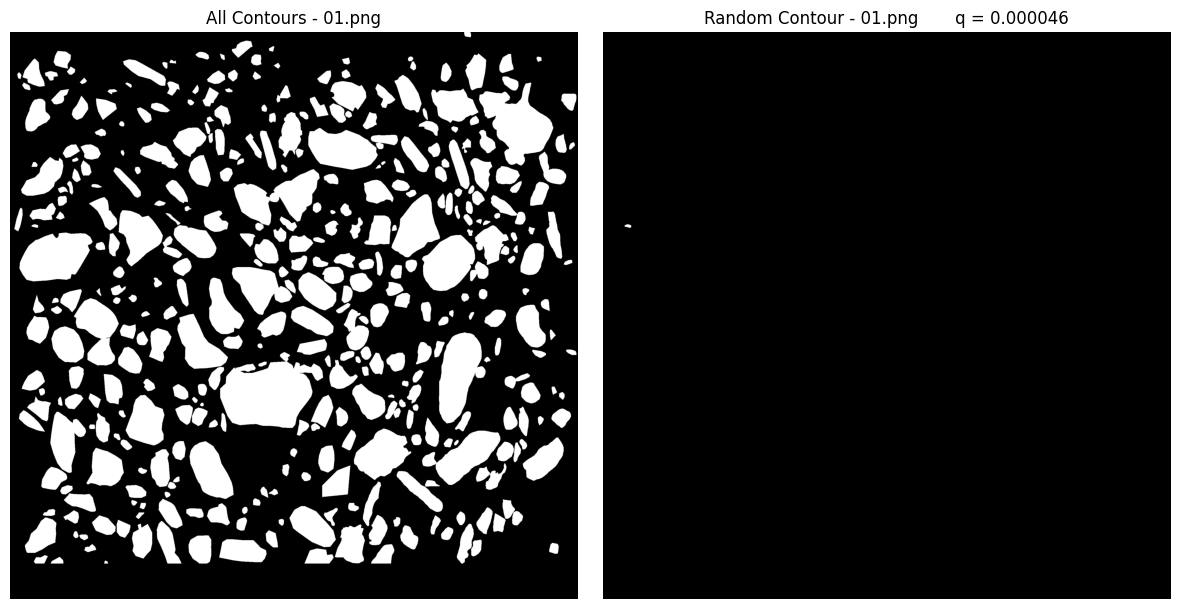

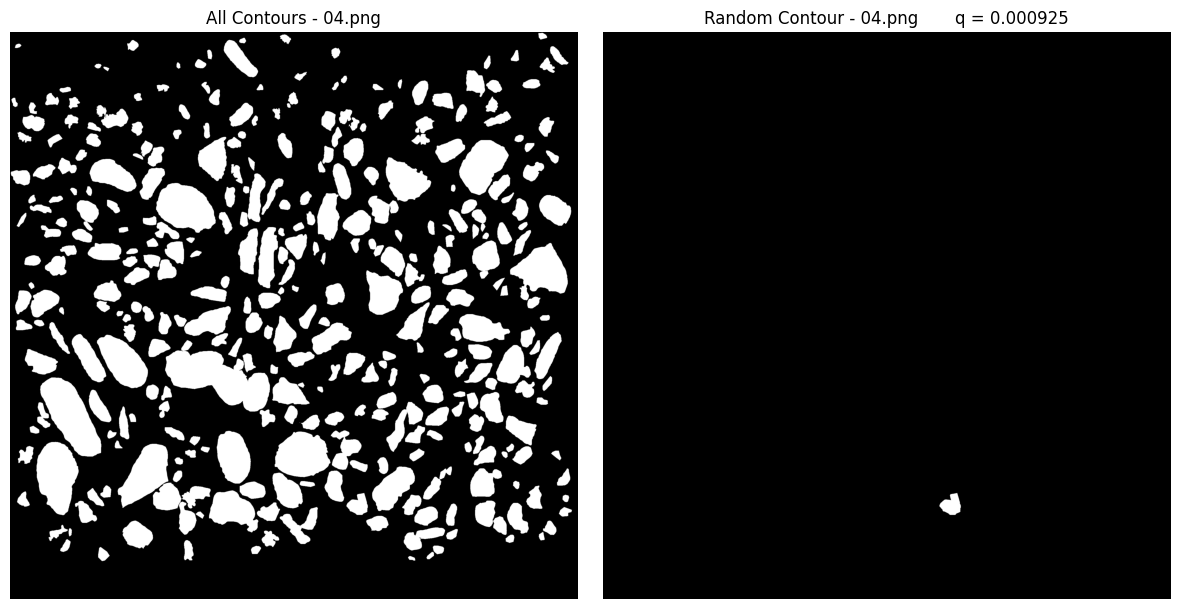

In [6]:
# Create a function to select one contour in dataset and plot it
# Put this function on the cell "# Functions" (see above)

plot_contours_from_json("dataset_contours_aggregate.json", keys_to_plot=["01.png", "04.png"])